### 1) Preprocessing

In [12]:
import os
import shutil
import shap
import numpy as np
import tensorflow as tf
from keras.utils import image_dataset_from_directory, load_img
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import  Input, Activation, Flatten, Conv2D, MaxPooling2D,  Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import cv2
from torchvision.transforms.functional import normalize

 1.1) Loading an image dataset from the 'flowers' directory using the image_dataset_from_directory function. It resizes the images to 128x128 pixels and groups them into batches of 32 images each for easier processing.

In [2]:
data = image_dataset_from_directory(
    'flowers',
    image_size=(128, 128),
    batch_size=32 
)

Found 1517 files belonging to 2 classes.


1.2) Labeling the images into arrays and appends them to the respective listsand normalizing the data, and since the pixel values of the images are normalized by dividing by 255.0, scaling the values to the range [0, 1].

In [3]:
images, labels = [], []
for image, label in data:
    images.append(image.numpy())
    labels.append(label.numpy())
images, labels = np.concatenate(images), np.concatenate(labels)
images /= 255.0

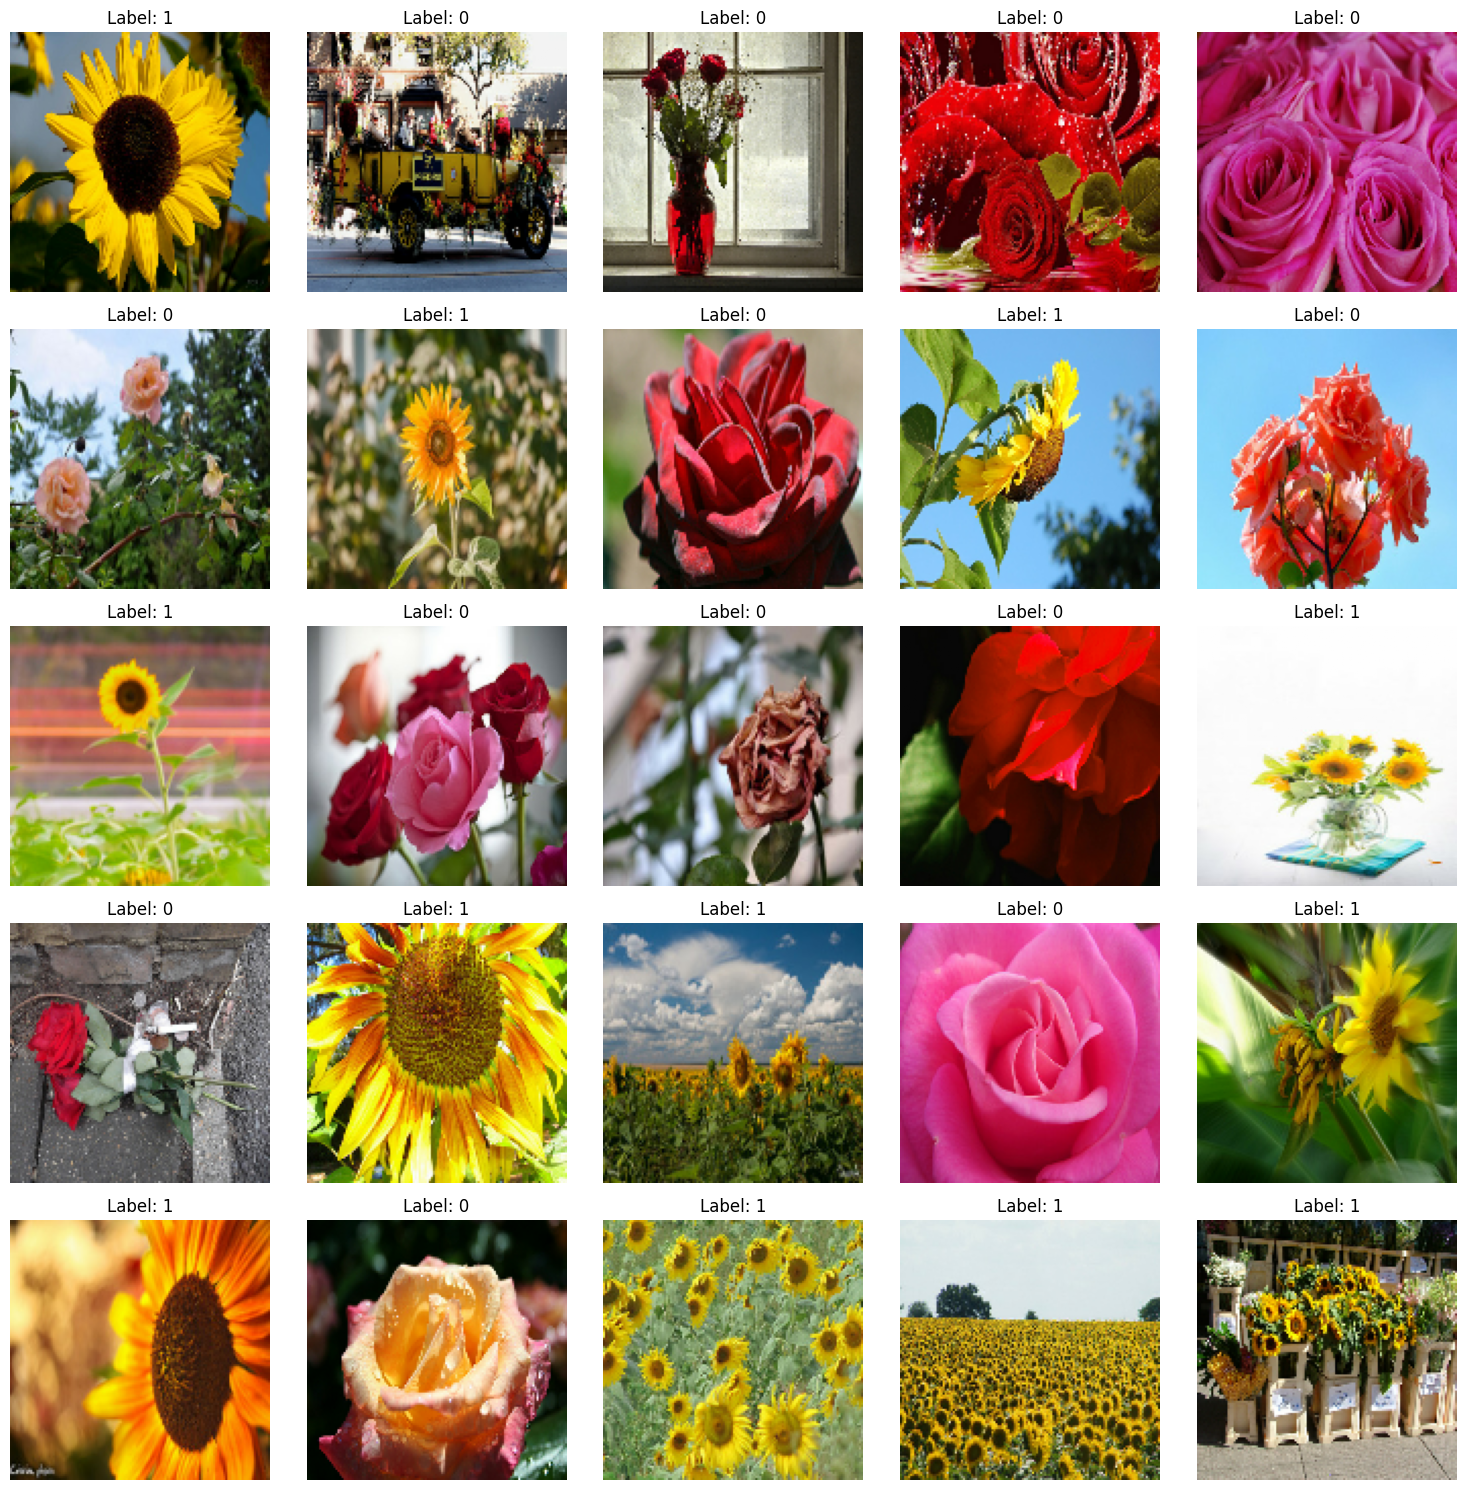

In [4]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i in range(25):
    axes[i].imshow(images[i])
    axes[i].axis('off') 
    axes[i].set_title(f"Label: {labels[i]}")

plt.tight_layout()

### 2) Buidling the model

2.1) Concatenating image and label arrays into training and testing sets using the train_test_split function. 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, shuffle=True, random_state=11, stratify=labels)

2.2) Training a convolutional neural network (CNN) for image classification.

**Model Architecture:**
- <u>Input Layer</u>: The model takes input images of shape (128, 128, 3), where 3 represents the RGB color channels.
- <u>Convolutional Layers:</u>
Conv2D layers apply convolution operations, using 32 filters in the first layer and 16 in the second, with a kernel size of 3x3 and ReLU activation.
MaxPooling2D layers downsample the feature maps by a factor of 2.
- <u>Flatten Layer:</u> The output from the convolutional layers is flattened into a 1D vector.
- Dense Layer: A fully connected layer with 3 output units (for 3 classes).
- <u>Softmax Activation:</u>The output layer uses softmax to produce class probabilities.

The model is compiled with the Adam optimizer, and converts the labels to one-hot encoded format for multi-class classification.

The training process uses a batch size of 32, runs for 10 epochs, and uses 15% of the training data for validation.

In [6]:
inputs = Input(shape=(128, 128, 3), name="Input")
x = Conv2D(32, 3, activation="relu", padding='same', name='Conv1')(inputs)
x = MaxPooling2D(2, name='Pool1')(x)
x = Conv2D(16, 3, activation="relu", padding='same', name='Conv2')(x)
x = MaxPooling2D(2, name='Pool2')(x)
x = Flatten(name='Vectorize')(x)
x = Dense(3, name='FC')(x)
outputs = Activation("softmax", name='Softmax')(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['acc'])
model.summary()

hist = model.fit(
    X_train,
    to_categorical(y_train, 3),
    batch_size=32,
    epochs=10,
    validation_split=0.15,
    shuffle='on'
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Vectorize (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC (Dense)                      │ (None, 3)              │        49,155 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Softmax (Activation)            │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,675 (213.57 KB)

 Trainable params: 54,675 (213.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - acc: 0.7024 - loss: 0.5895 - val_acc: 0.8480 - val_loss: 0.3384
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - acc: 0.8527 - loss: 0.3260 - val_acc: 0.8713 - val_loss: 0.2756
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - acc: 0.8906 - loss: 0.2457 - val_acc: 0.8596 - val_loss: 0.2929
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - acc: 0.9251 - loss: 0.2035 - val_acc: 0.8947 - val_loss: 0.2482
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - acc: 0.8978 - loss: 0.2642 - val_acc: 0.9006 - val_loss: 0.2397
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - acc: 0.9433 - loss: 0.1749 - val_acc: 0.9006 - val_loss: 0.2459
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - acc: 0.9595 - loss: 0.1256 - val_acc: 0.8889 - val_loss: 0.3127
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - acc: 0.9669 - loss: 0.1084 - val_acc: 0.8538 - val_loss: 0.4298
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - acc: 0.9537

2.3) Evaluating the performance of the trained CNN model on the test

In [7]:
y_hat=model.predict(X_test)
print('Acc=',np.sum(y_hat.argmax(1)==y_test)/y_test.shape[0])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Acc= 0.9289473684210526


### 3) Shap

3.1)  SHAP (SHapley Additive exPlanations) to explain the model's predictions for a specific test image from the dataset. 

- Taking an input x, makes a copy of it, and passes it to the trained model to get predictions.
- Creating a SHAP masker that will generate blurred versions of the input images.

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.69s/it]               


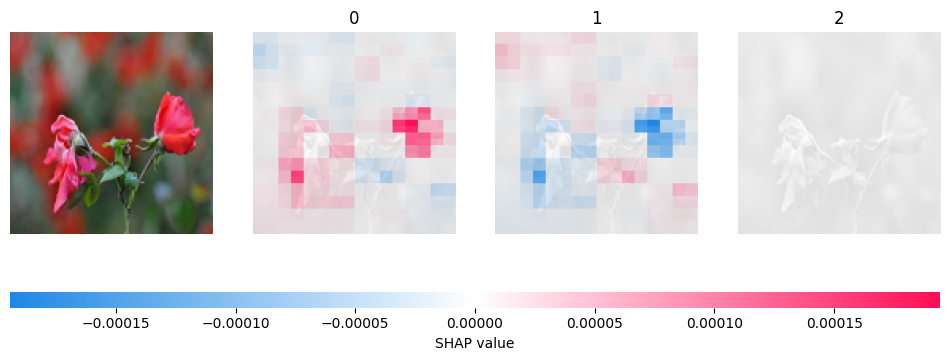

In [8]:
def f(x):
    tmp = x.copy()
    return model(tmp)
masker_blur = shap.maskers.Image("blur(128,128)", X_test[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(3)))
ind=[311]
shap_values_ = explainer( X_test[ind], max_evals=5000, batch_size=50 )     
shap.image_plot(shap_values_,labels=[0,1,2])

### 4) ProPnet

#### Step1:
Define data transforms and load the full dataset

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root='flowers', transform=transform)

#### Step 2:
Split dataset into train and test sets using indices

In [5]:
train_indices, test_indices = train_test_split(
    np.arange(len(dataset)),
    test_size=0.2,
    stratify=dataset.targets,
    random_state=11
)

train_data = Subset(dataset, train_indices)
test_data = Subset(dataset, test_indices)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

#### Step 3:
Define a simple ProtoPNet model architecture

In [6]:
class SimpleProtoPNet(nn.Module):
    def __init__(self, num_prototypes, num_classes):
        super(SimpleProtoPNet, self).__init__()
        # Backbone structure
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16 * 32 * 32, num_classes)
        )
        self.num_prototypes = num_prototypes
        self.num_classes = num_classes

    def forward(self, x):
        return self.backbone(x)

#### Step 4:
Instantiate the model


In [7]:
num_prototypes = 20  # Number of prototypes per class
num_classes = len(dataset.classes)  # 2 for rose and sunflower
model = SimpleProtoPNet(num_prototypes=num_prototypes, num_classes=num_classes)

#### Step 5:
Set up training elements

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# To record loss and accuracy for plotting
train_losses = []
test_accuracies = []

#### Step 6:
Training the ProtoPNet model

In [9]:
for epoch in range(10):  # 10 epochs to match the previous setup
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)
    print(f"Epoch {epoch+1}, Loss: {average_loss}")

    # Evaluate on the test set after each epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Test Accuracy after Epoch {epoch+1}: {accuracy:.2f}%")

Epoch 1, Loss: 0.34434258722160993
Test Accuracy after Epoch 1: 89.80%
Epoch 2, Loss: 0.23978177820773502
Test Accuracy after Epoch 2: 87.17%
Epoch 3, Loss: 0.19119850742189506
Test Accuracy after Epoch 3: 92.11%
Epoch 4, Loss: 0.1632601990315475
Test Accuracy after Epoch 4: 90.13%
Epoch 5, Loss: 0.12728199029439374
Test Accuracy after Epoch 5: 88.49%
Epoch 6, Loss: 0.10188923888888798
Test Accuracy after Epoch 6: 89.80%
Epoch 7, Loss: 0.07328757866726894
Test Accuracy after Epoch 7: 88.49%
Epoch 8, Loss: 0.06835589550533577
Test Accuracy after Epoch 8: 89.80%
Epoch 9, Loss: 0.04192569827366816
Test Accuracy after Epoch 9: 90.79%
Epoch 10, Loss: 0.029083204394402474
Test Accuracy after Epoch 10: 88.82%


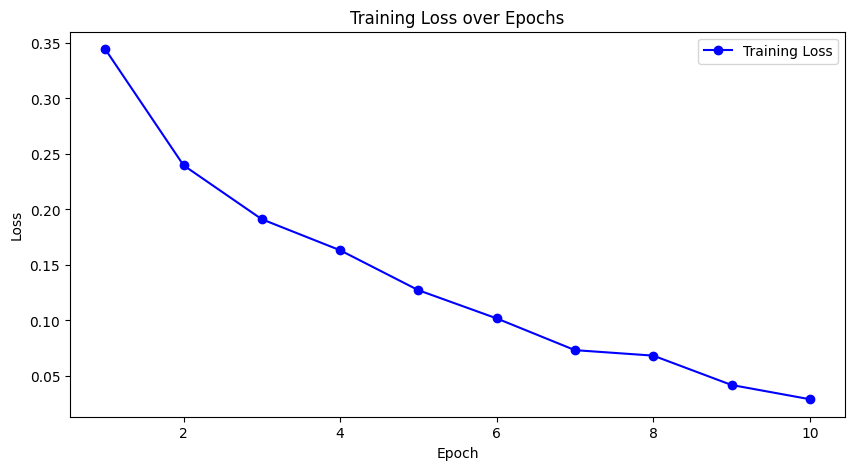

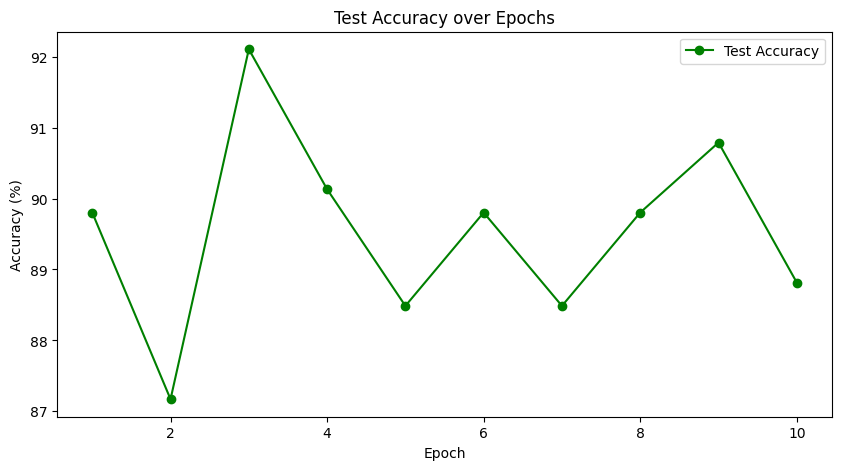

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_losses, marker='o', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), test_accuracies, marker='o', color='g', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.show()

#### Step 7:
Prototype Assignment

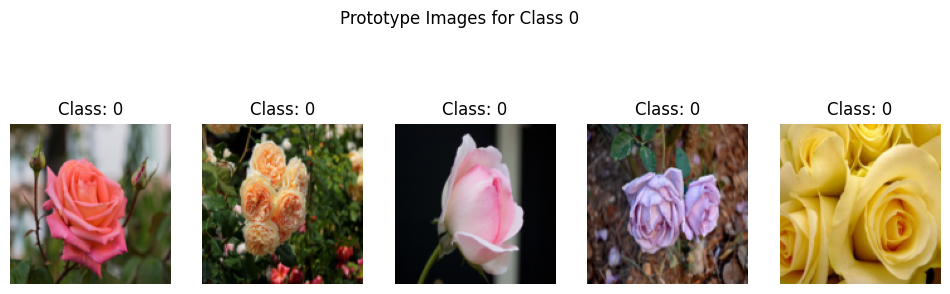

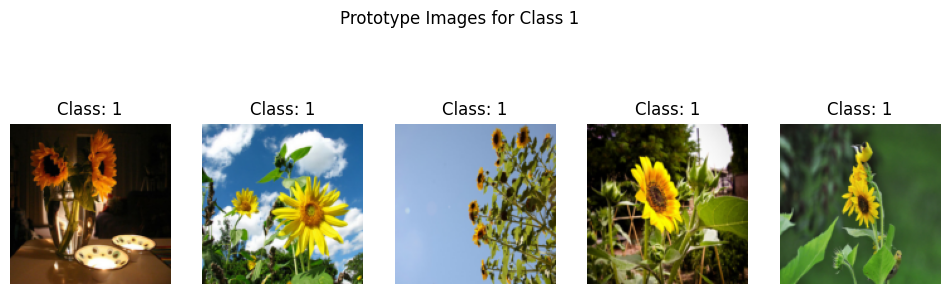

In [20]:
def push_prototypes(model, train_loader, num_prototypes_per_class=5):
    model.eval()
    prototype_images = {i: [] for i in range(model.num_classes)}

    with torch.no_grad():
        for images, labels in train_loader:
            outputs = model(images)
            for i in range(images.size(0)):
                label = labels[i].item()
                if len(prototype_images[label]) < num_prototypes_per_class:
                    prototype_images[label].append(images[i])

    # Display prototype images
    for class_id, images in prototype_images.items():
        plt.figure(figsize=(12, 4))
        for i, image in enumerate(images):
            plt.subplot(1, num_prototypes_per_class, i + 1)
            plt.imshow(image.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize for display
            plt.title(f"Class: {class_id}")
            plt.axis('off')
        plt.suptitle(f'Prototype Images for Class {class_id}')
        plt.show()


push_prototypes(model, train_loader)

#### Step 8:
Grad-CAM function to generate heatmaps for ProtoPNet predictions

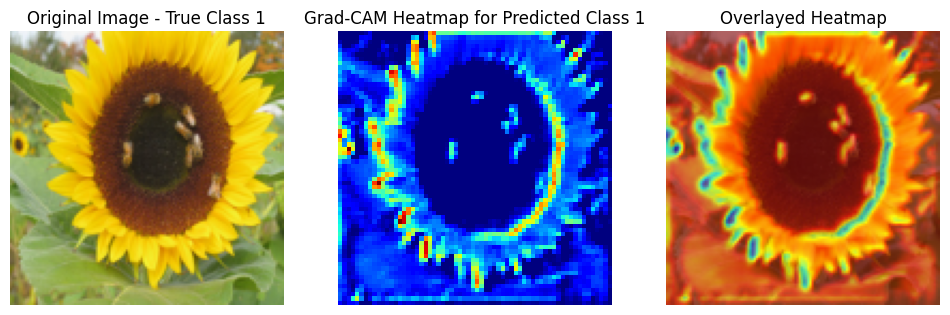

In [21]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import normalize

def generate_gradcam_heatmap(model, image, target_class):
    # Set the model to evaluation mode
    model.eval()
    image = image.unsqueeze(0)  
    image.requires_grad = True  

    conv_layer = None
    for layer in model.backbone:
        if isinstance(layer, nn.Conv2d):
            conv_layer = layer

    # Get the conv output by registering a hook
    conv_output = None
    def hook_fn(module, input, output):
        nonlocal conv_output
        conv_output = output
        output.retain_grad()  

    
    handle = conv_layer.register_forward_hook(hook_fn)

    output = model(image)
    pred = output[0][target_class]
    
    model.zero_grad()
    pred.backward()

    gradients = conv_output.grad[0].cpu().numpy()
    conv_output = conv_output[0].cpu().detach().numpy()

    pooled_gradients = np.mean(gradients, axis=(1, 2))

    for i in range(conv_output.shape[0]):
        conv_output[i, :, :] *= pooled_gradients[i]


    heatmap = np.mean(conv_output, axis=0)
    heatmap = np.maximum(heatmap, 0)  
    heatmap /= np.max(heatmap) 


    handle.remove()
    return heatmap



def overlay_heatmap(heatmap, image, alpha=0.6, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlayed_image = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return overlayed_image


def show_gradcam_on_test_image(model, test_loader, target_class):
    images, labels = next(iter(test_loader))
    test_image = images[0]  # Select the first image
    label = labels[0].item()


    model.eval()
    with torch.no_grad():
        pred = model(test_image.unsqueeze(0)).argmax(1).item()

    heatmap = generate_gradcam_heatmap(model, test_image, pred)

    original_image = test_image.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Unnormalize
    original_image = (original_image * 255).astype(np.uint8)
    heatmap_image = overlay_heatmap(heatmap, original_image)


    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title(f"Original Image - True Class {label}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title(f"Grad-CAM Heatmap for Predicted Class {pred}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(heatmap_image)
    plt.title("Overlayed Heatmap")
    plt.axis('off')
    plt.show()

show_gradcam_on_test_image(model, test_loader, target_class=1)
